In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import warnings

import geopandas as gpd
import geoplot as gplt
from adjustText import adjust_text

from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("white")
sns.set_context("notebook")

from pathlib import Path

## Meta data

In [2]:
meta_data = pd.read_excel('../metadata/Papio-Genomes_JR_120720_MR-CR-KM.xlsx')
meta_data.head()

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex
0,PD_0067,1043,Roos,Theropithecus,gelada,captive,M
1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F
2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F
3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M
4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F


Assign 'U' as unknown sex:

In [3]:
meta_data.loc[meta_data.Sex.isnull(), 'Sex'] = 'U'

Set https proxy. Jupyter does not inherrit the one set set for other shells.

In [11]:
%env https_proxy=http://in:3128 

env: http_proxy=http://in:3128


Automacially retrieve geolocations:

In [12]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="baboon_map")
geolocations = dict()
unidentifiable = set()
for loc in meta_data.Origin:
    geoloc = geolocator.geocode(loc)
    if geoloc:
        geolocations[loc] = geoloc
    else:
        unidentifiable.add(loc)

GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=captive&format=json&limit=1 (Caused by ProxyError('Cannot connect to proxy.', NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x2b524b9b0b10>: Failed to establish a new connection: [Errno 111] Connection refused')))

Unidentifiable locations:

In [13]:
unidentifiable

set()

Get the last ones manually...

In [14]:
class dummy_geo():
    def __init__(self, *args, **kwargs):
        for key, val in kwargs.items():
            setattr(self, key, val)
manual_geolocations = dict()
manual_geolocations['Dendro Park, Zambia'] = dummy_geo(
    address='Dendro Balla Balla Safaris, Namwala, Zambia', 
    latitude=-16.145437871122923, longitude=26.062549952570674)
manual_geolocations['Filoha, Ethiopia'] = dummy_geo(
    address='Awash National Park in Ethiopia', 
    latitude=9.083582259300927, longitude=40.00000536178701)
manual_geolocations['Gog Woreda, Gambella region, Ethiopia'] = dummy_geo(
    address='Gambrella National Park, Ethiopia', 
    latitude=8.07396896853714, longitude=34.17906287308874)

Add manual geolocations:

In [15]:
geolocations.update(manual_geolocations)

Augment meta data with geolocations:

In [16]:
meta_data['address'] = [geolocations[loc].address for loc in meta_data.Origin]                                      
meta_data['longitude'] = [geolocations[loc].longitude for loc in meta_data.Origin]                                      
meta_data['latitude'] = [geolocations[loc].latitude for loc in meta_data.Origin]                                                           

KeyError: 'captive'

In [17]:
meta_data.head()

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex
0,PD_0067,1043,Roos,Theropithecus,gelada,captive,M
1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F
2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F
3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M
4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F


In [ ]:
meta_data.to_excel('../metadata/Papio-Genomes_JR_120720_MR-CR-KM_geoloc.xlsx')

In [18]:
meta_data = pd.read_excel('../metadata/Papio-Genomes_JR_120720_MR-CR-KM_geoloc.xlsx')

## Colors

In [19]:
#mycols = sns.color_palette(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00','#6a3d9a', 'deeppink'])
mycols = sns.color_palette(['#33a02c', '#FFB100', "#8d9da3", '#1f78b4', '#e31a1c', '#b15928'])
mycols_cmap = ListedColormap(mycols.as_hex())
mycols

[(0.2, 0.6274509803921569, 0.17254901960784313),
 (1.0, 0.6941176470588235, 0.0),
 (0.5529411764705883, 0.615686274509804, 0.6392156862745098),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

## Baboon range data

Decryptshape data:

In [26]:
! python ../scripts/encrypt.py -d banana ../metadata/baboon_range_shape_data

Unpack zip files:

In [29]:
! for Z in ../metadata/baboon_range_shape_data/*.zip; do unzip -d ${Z%.*} $Z; done

Archive:  ../metadata/baboon_range_shape_data/redlist_species_data_016c0a37-4ebb-476d-8516-50da3349e81c.zip
  inflating: data_0.shx              
  inflating: data_0.prj              
  inflating: data_0.dbf              
  inflating: IUCN Red List_Terms and Conditions of Use_v3.pdf  
  inflating: ReadMe.txt              
  inflating: METADATA for Digital Distribution Maps of The IUCN Red List of Threatened Species.pdf  
  inflating: data_0.shp              
  inflating: data_0.cpg              
Archive:  ../metadata/baboon_range_shape_data/redlist_species_data_0edf3d32-cbef-4ea3-bb8d-a4513edf4d89.zip
replace data_0.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Archive:  ../metadata/baboon_range_shape_data/redlist_species_data_46e65614-dd15-46a9-8018-c2c4a627bb88.zip
replace data_0.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [31]:
geodata_dir = Path('../metadata/baboon_range_shape_data')
ranges_gdf = pd.concat(gpd.read_file(path) for path in geodata_dir.glob('**/*.shp'))


## Map data

In [34]:
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)
world.columns

Index(['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry'], dtype='object')

In [33]:
world_midres = gpd.read_file(
    '../metadata/mapdata/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp'
)
world_midres.columns
world_midres['continent'] = world_midres.CONTINENT
world_midres['name'] = world_midres.NAME_EN

DriverError: ../metadata/mapdata/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp: No such file or directory

In [35]:
world.name.unique().size, world_midres.name.unique().size

NameError: name 'world_midres' is not defined

In [36]:
world.total_bounds.round().tolist()

[-180.0, -90.0, 180.0, 84.0]

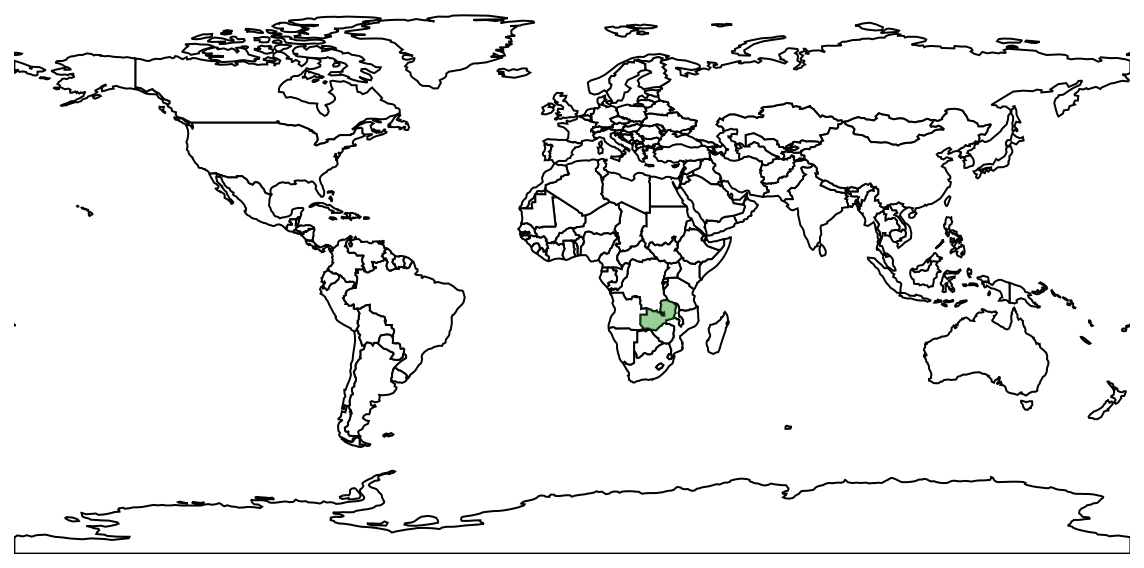

In [37]:
ax = gplt.polyplot(world,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    world.loc[world.name == 'Zambia'], hue='name', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, cmap=mycols_cmap, extent=world.total_bounds.round()
) ;


In [38]:
# africa = world[world.continent == 'Africa']
africa = world[(world.continent == 'Africa') | (world.name.isin(['Saudi Arabia', 'Yemen', 'Oman', 'United Arab Emirates',
                           'Israel', 'Jordan', 'Qatar', 'Kuwait']))]
africa_midres = world_midres[(world_midres.continent == 'Africa') | (world_midres.name.isin(['Saudi Arabia', 'Yemen', 'Oman', 'United Arab Emirates',
                           'Israel', 'Jordan', 'Qatar', 'Kuwait']))]

NameError: name 'world_midres' is not defined

In [ ]:
africa.name.unique().size, africa_midres.name.unique().size

## Clean map

In [ ]:
# world.loc[world.name.isin(['Saudi Arabia', 'Yemen', 'Oman', 'United Arab Emirates',
#                            'Israel', 'Jordan', 'Qatar', 'Kuwait'])]

ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
plt.savefig('../figures/ranges.pdf')

## GeoDataFrame

In [ ]:
gdf = gpd.GeoDataFrame(meta_data, geometry=gpd.points_from_xy(meta_data.longitude, meta_data.latitude)).loc[lambda df: df.Species != 'gelada']
gdf.loc[gdf.Species == 'ursinus (grayfoot)', 'Species'] = 'ursinus'
gdf.head()

## Sampling locations for each species

In [ ]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
# get legend
leg1 = ax.axes.get_legend()

# overwrites first legend
gplt.pointplot(gdf, ax=ax, extent=africa.total_bounds, marker='x',
               zorder=10, s=7, hue='Species', legend=True, cmap=mycols_cmap, 
              legend_kwargs=dict(loc='lower right'));

# manually add the first legend back
ax.add_artist(leg1); 

## Plot with each sample as male or female

In [ ]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;

gplt.pointplot(gdf.loc[gdf.Sex=='F'], ax=ax, extent=africa.total_bounds, marker="$\u2640$",
               zorder=10, s=10, color='black');
gplt.pointplot(gdf.loc[gdf.Sex=='M'], ax=ax, extent=africa.total_bounds, marker="$\u2642$",
               zorder=10, s=10, color='black');

In [ ]:
gdf['dummy'] = np.random.random(gdf.index.size)

In [ ]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;

gplt.pointplot(gdf, ax=ax, extent=africa.total_bounds, marker='o', #scheme=None,
               zorder=10, s=10, hue='dummy', legend=True, 
               legend_kwargs=dict(shrink=0.4), 
               cmap='inferno');

## Numbers of samples at each location

In [ ]:
geo_loc = (gdf[['Origin', 'Species', 'Sex', 'geometry']]
           .dissolve(by=["Origin", 'Species'], 
                     aggfunc='count').rename(columns={'Sex': 'nr_samples'})
           .reset_index()
          )
geo_loc

In [ ]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
# get legend
leg1 = ax.axes.get_legend()

def scale_func(minval, maxval):
    def scalar(val):
        return val / 3
    return scalar

# overwrites first legend
gplt.pointplot(geo_loc, ax=ax, extent=africa.total_bounds,
               zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
               color='grey',
               #fillstyle='none', 
#                scatter_kws = {'fillstyle':'none'},
               edgecolors='black',
               legend_kwargs=dict(loc='lower right'),
              );

# manually add the first legend back
ax.add_artist(leg1); 

## Numbers of males sampled at each location

In [ ]:
geo_loc = (gdf.loc[gdf.Sex == 'M', ['Origin', 'Species', 'Sex', 'geometry']]
           .dissolve(by=["Origin", 'Species'], 
                     aggfunc='count').rename(columns={'Sex': 'nr_samples'})
           .reset_index()
          )
geo_loc

In [ ]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
# get legend
leg1 = ax.axes.get_legend()

def scale_func(minval, maxval):
    def scalar(val):
        return val / 2
    return scalar

# overwrites first legend
gplt.pointplot(geo_loc, ax=ax, extent=africa.total_bounds,
               zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
               color='grey',
               #fillstyle='none', 
#                scatter_kws = {'fillstyle':'none'},
               edgecolors='black',
               legend_kwargs=dict(loc='lower right'),
              );

# manually add the first legend back
ax.add_artist(leg1); 

In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 12))


ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', ax=ax)
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
# get legend
leg1 = ax.axes.get_legend()

def scale_func(minval, maxval):
    def scalar(val):
        return val / 3
    return scalar

# overwrites first legend
gplt.pointplot(geo_loc, ax=ax, extent=africa.total_bounds,
               zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
               color='grey',
               #fillstyle='none', 
#                scatter_kws = {'fillstyle':'none'},
               edgecolors='black',
               legend_kwargs=dict(loc='lower right', markeredgecolor='black'),
              );

texts = []
for x, y, label in zip(geo_loc.geometry.x, geo_loc.geometry.y, [x.split(',')[0] for x in geo_loc.Origin]):
    texts.append(ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", zorder=10, size=8))
adjust_text(texts)
    
# manually add the first legend back
ax.add_artist(leg1); 


ax = gplt.polyplot(africa_midres,
    facecolor='white', edgecolor='black', ax=ax2)
ax.set_facecolor('white')

extent = (28, -11, 40, 0)

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax2, 
    extent=extent,
    cmap=mycols_cmap, legend=True,
) ;
# get legend
leg1 = ax2.axes.get_legend()

def scale_func(minval, maxval):
    def scalar(val):
        return val
    return scalar

# overwrites first legend
gplt.pointplot(geo_loc, ax=ax2, extent=extent,
               zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
               color='grey',
               #fillstyle='none', 
#                scatter_kws = {'fillstyle':'none'},
               edgecolors='black',
               legend_kwargs=dict(loc='lower right', markeredgecolor='black', markerfacecolor='none'),
              );

texts = []
for x, y, label in zip(geo_loc.geometry.x, geo_loc.geometry.y, [x.split(',')[0] for x in geo_loc.Origin]):
    if extent[0] < x < extent[2] and extent[1] < y < extent[3]:
        texts.append(ax2.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", zorder=10, size=15))
adjust_text(texts)        

plt.savefig('../figures/baboon_samples.pdf')